## `Modeling plan`
---
1. [Importing data](#importing-and-shaping-data-for-modeling)
2. [Baseline model with TF-IDF and MutinomialNB](#modeling-baseline-with-tfidf-and-mnb)
3. [We will test a selection of models](#lets-compare-the-following-3-models) 
- Random forests (TVEC vs CVEC)
- Multinomial NB (TVEC vs CVEC)
- Logistic regression (TVEC vs CVEC)<br>

[and compare them to evaluate individual performance](#on-to-metrics-comparison).<br>

Finally, we attempted to push the project on streamlit using Flask, Docker and GCP, but resulted in error on streamlit

In [1]:
# importing data manipulation
import pandas as pd
import numpy as np

#importing sklearn tools for modelling
from sklearn.model_selection import train_test_split, GridSearchCV # split our data and run hyperparameter search
from sklearn.pipeline import Pipeline # to compactly pack multiple modeling operations

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB # to build our classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to access results from binary classification task (you may also import other specific classification metrics)
from sklearn.metrics import plot_roc_curve, precision_score, recall_score, f1_score, accuracy_score,roc_auc_score

# pass regex in r'regex for match-filter'
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # for stopwords removal
from nltk.stem import PorterStemmer

#importing visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Settings
sns.set_style("darkgrid") # setting seaborn style

# enable inline plotting
%matplotlib inline 

pd.set_option('display.max_columns', None) # disable column overflow in pandas display

### `Importing and shaping data for modeling`

In [3]:
df_concat = pd.read_csv('.\\transformed_csv\df_concat_part2.csv')

In [4]:
df_concat.shape #checking we got what we left in Part1

(5801, 8)

In [5]:
df_concat.columns

Index(['Unnamed: 0', 'subreddit', 'selftext', 'title', 'no_stopwords_selftext',
       'unigrams_no_stopwords', 'selftext_lemmatized', 'len_posts'],
      dtype='object')

In [6]:
df_concat.drop(columns=['Unnamed: 0','unigrams_no_stopwords','selftext_lemmatized','no_stopwords_selftext','title'], inplace=True)
df_concat.shape

(5801, 3)

In [7]:
df_concat.head()

,subreddit,selftext,len_posts
0,DunkinDonuts,pumpkin small: $1.99\n\noriginal small: $2.29\...,282
1,DunkinDonuts,a few weeks ago someone posted a comment about...,622
2,DunkinDonuts,"our nearest dunkin is a bit of a drive, and th...",212
3,DunkinDonuts,how do i ask for an extra shot of flavor in th...,379
4,DunkinDonuts,i’ve used a can of monster and a variable amou...,134


### `Mapping target variable to 1 for Dunkin and 0 for Starbucks`

In [8]:
df_concat['subreddit']= df_concat['subreddit'].map({'DunkinDonuts':1,'starbucks':0})

In [9]:
df_concat.head()

,subreddit,selftext,len_posts
0,1,pumpkin small: $1.99\n\noriginal small: $2.29\...,282
1,1,a few weeks ago someone posted a comment about...,622
2,1,"our nearest dunkin is a bit of a drive, and th...",212
3,1,how do i ask for an extra shot of flavor in th...,379
4,1,i’ve used a can of monster and a variable amou...,134


### `Data Dictionary`

| Data Dictionary | Description |
| ----------- | ----------- |
| subreddit | where is the record from (0 = Dunkin, 1=Starbucks) |
| selftext | text belonging to the thread |
|len_posts | post length in words|

### `Metrics we will evaluate:`
---

1. F1 Score
- The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.
- The F1 score is the harmonic mean of the precision and recall

2. Precision score: Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative

3. Accuracy Score: The easiest metric to understand: either the fraction of correct predictions.

4. Recall score: 
- In binary classification, recall is called sensitivity. It can be viewed as the probability that a relevant document is retrieved by the query.

## `Modeling process`
---

### `Baseline  TF-IDF and NaiveBayes`
-------

We will **lemmatize**, **vectorize (using TF-IDF)** and feed the data to Multinomial NaiveBayes

In [10]:
%%time
#lemmatizing our data


lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# set up the lemmatizer
lemmatized_posts = []
for post in df_concat['selftext']:
    tokens = tokenizer.tokenize(post)
    post = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(' '.join(post))
    
# append the lemmatized posts to the DataFrame
df_concat['selftext_lemmatized'] = lemmatized_posts

CPU times: total: 4.38 s
Wall time: 4.67 s


In [11]:
#spliting our X and y
X=df_concat['selftext_lemmatized'] #selecting only selftext to predict our origin subreddit
y=df_concat['subreddit']
# define training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, #usefull to make sure each fold contains a fair share of positive and negative class. In our case, the dataset is balanced so not very critical
                                                    random_state=42)

### `Preparing objects for the notebook`

Putting it together: TF-IDF
To summarize the key intuition motivating TF-IDF is the importance of a term is inversely related to its frequency across documents.TF gives us information on how often a term appears in a document and IDF gives us information about the relative rarity of a term in the collection of documents. By multiplying these values together we can get our final TF-IDF value [^1]

[1^] *https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/*

In [12]:
#adding the stopwords to the pipe
new_stopwords = ["dunkin", "Dunkin", "DunkinDonuts", "donuts", "starbucks", "Starbucks","sbucks","Sbucks"] 
model_stopwords = stopwords.words('english')
model_stopwords.extend(new_stopwords)

#instantiating vectorizers
tvec = TfidfVectorizer(stop_words=model_stopwords) #instantiating the tf-idf object and removing stopswords - in case stop words are not the same from nltk corpus


# Countvectorizer
cvec= CountVectorizer(stop_words=model_stopwords) #max_features : “If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.”

In [13]:
#instanciating Models
#NaiveBayes
mNB =MultinomialNB()

In [14]:
#let's store all models performance in a list that we can use to compare at the end  
models_scores_list =[]

In [15]:
#create a dictionary for each model to store performance
results_01 = {}

# instantiate Logistic Regression model 
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec = Pipeline([
    ('tvec', tvec), # we execute the vectorization using tvec tuned with new stop words. by default, tvec grams are (1,1), which is what we want
    ('nb', mNB)
])

# update the results list 
results_01['model'] = 'pipe_tvec'
results_01['vectorizer'] = 'tvec'


In [16]:
# Estimate how your model performs on training data
cross_val_score(pipe_tvec, X_train, y_train, cv=3).mean()
# score is the mean accuracy ( correct predictions / total preds), as we are using MNB estimator

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(
c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(
c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


0.7923347951125729

79% accuracy score, not bad for a first try  

In [17]:
# Fitting the model. fit = "".learn"
pipe_tvec.fit(X_train, y_train)

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('tvec',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [18]:
# Training score
pipe_tvec.score(X_train, y_train) 
#Return the mean accuracy on the given test data and labels.
#We are happy to use this as we simply want to classify post origin, so we want the TP + TN over the total.
#Specificity and recall matter less for this example

0.8710756562017499

In [19]:
preds = pipe_tvec.predict(X_test) #evaluating our baseline model on preds

In [20]:
confusion_matrix(y_test, preds) #run the confusion matrix

array([[939, 105],
       [257, 614]], dtype=int64)

In [21]:
# ravel() to convert to 1-D and Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)

939 105 257 614


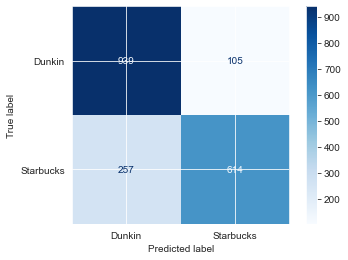

In [22]:
# plot confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dunkin', 'Starbucks'])
disp.plot(cmap=plt.cm.Blues)

In [23]:
#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

# update various metrics onto results list
results_01['accuracy'] = accuracy
results_01['recall'] = recall
results_01['precision'] = precision
results_01['f1_score'] = f1score
results_01['roc_auc'] = roc_auc

#storing metrics for later
models_scores_list.append(results_01)

# checking it works fine
models_scores_list

[{'model': 'pipe_tvec',
  'vectorizer': 'tvec',
  'accuracy': 0.8109660574412533,
  'recall': 0.7049368541905855,
  'precision': 0.8539638386648123,
  'f1_score': 0.7723270440251573,
  'roc_auc': 0.8021810707734537}]

- In our context, we really want the highest accuracy score to make sure that posts are classified in the correct subreddit. 
- Type 1 and type 2 errors are not extremely critical, worst case a post is not directed to the right subreddit.( not great, but worse things in life)

## `Let's compare the following 3 models`
---
- Random forests (TFIDF vs CVEC)
- NaiveBayes (TFIDF vs CVEC)
- Logisitc Regression (TFIDF vs CVEC)

## `Random Forests`
---

Let's remember what Random forests do: **from notebook**<br>

*In summary, Bagging is an ensemble algorithm that fits multiple models on different subsets of a training dataset, then combines the predictions from all models.*

*Random forest is an extension of bagging that also randomly selects subsets of features used in each data sample. Random forest is another ensemble of decision tree models and may be considered an improvement upon bagging. The main difference is that all features (variables or columns) are not used; instead, a small, randomly selected subset of features (columns) is chosen for each bootstrap sample. This has the effect of de-correlating the decision trees (making them more independent), and in turn, improving the ensemble prediction*


In [24]:
#RandomForest
rf = RandomForestClassifier()

Let's start with TFIDF

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


Our F1 score is : 0.7533805537669027
Our Precision score is : 0.8577712609970675
Our accuracy score is : 0.8
Our recall score is : 0.6716417910447762
CPU times: total: 1.78 s
Wall time: 23.5 s


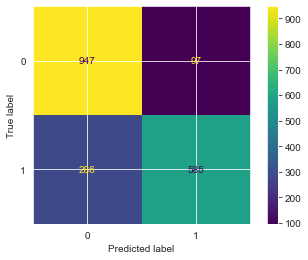

In [25]:
%%time
# update the results list 
results_02={}
results_02['model'] = 'RandomF_TFIDF'
results_02['vectorizer'] = 'tvec'

# Set up a pipeline with tf-idf vectorizer and random forest
pipe_tvec = Pipeline([
    ('tvec', tvec), #this tvec object has been set to remove stop words
    ('rf', rf)
])

#Preping for the gridsearch with random forest params
rf_params = {
    'rf__n_estimators': [50, 100, 250], # iterating over different number of trees in the forest
    'rf__min_samples_split':[2,5,10], # minimum different elements in one features to split the tree further
    'rf__max_depth': [10, 20]# iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure
    }

#using GridsearchCv to find the best parameters for this model
gscv_rf = GridSearchCV(
    pipe_tvec, 
    param_grid=rf_params, 
    cv=3, #cross validate our data
    verbose =1,
    n_jobs=-1)

#fitting model
gscv_rf.fit(X_train, y_train)

#getting predictions to evaluate performance
preds = gscv_rf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();


#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

#printing
print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_02['accuracy'] = accuracy
results_02['recall'] = recall
results_02['precision'] = precision
results_02['f1_score'] = f1score
results_02['roc_auc'] = roc_auc

models_scores_list.append(results_02)

Same with CVEC

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


Our F1 score is : 0.7664281067013662
Our Precision score is : 0.8843843843843844
Our accuracy score is : 0.812532637075718
Our recall score is : 0.6762342135476463
CPU times: total: 2.34 s
Wall time: 19.1 s


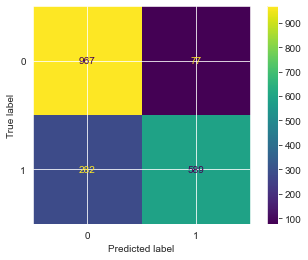

In [26]:
%%time

# update the results list 
results_03={}
results_03['model'] = 'RandomF_CVEC'
results_03['vectorizer'] = 'cvec'

# Set up a pipeline with tf-idf vectorizer and random forest
pipe_tvec = Pipeline([
    ('cvec', cvec), #this tvec object has been set to remove stop words
    ('rf', rf)
])

#Preping for the gridsearch with random forest params
rf_params = {
    'rf__n_estimators': [50, 100, 250], # iterating over different number of trees in the forest
    'rf__min_samples_split':[2,5,10], # minimum different elements in one features to split the tree further
    'rf__max_depth': [10, 20]# iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure
    }

#using GridsearchCv to find the best parameters for this model
gscv_rf = GridSearchCV(
    pipe_tvec, 
    param_grid=rf_params, 
    cv=3, #cross validate our data
    verbose =1,
    n_jobs=-1)


gscv_rf.fit(X_train, y_train)
#getting predictions to evaluate performance
preds = gscv_rf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

#getting the metrics ready

f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

#printing
print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_03['accuracy'] = accuracy
results_03['recall'] = recall
results_03['precision'] = precision
results_03['f1_score'] = f1score
results_03['roc_auc'] = roc_auc

models_scores_list.append(results_03)

## `Naive Bayes`
---

In [27]:
#Naive Bayes
mNB =MultinomialNB() 
# because our predicted variable is 0 or 1 (DD or Starbcuks)
#- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): 
# choose when our variables are positive integers or fractional counts. (we'll be using this mostly)
#The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
# The multinomial distribution normally requires integer feature counts. 
# However, in practice, fractional counts such as tf-idf may also work.

Starting with TFIDF

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


Our F1 score is : 0.8042704626334519
Our Precision score is : 0.8319018404907975
Our accuracy score is : 0.8276762402088773
Our recall score is : 0.7784156142365097


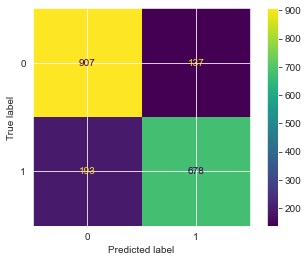

In [28]:
results_04={}
results_04['model'] = 'NaiveB_TFIDF'
results_04['vectorizer'] = 'tvec'

# Instantiating a pipeline.
text_clf_pipe = Pipeline(
    [
    ('tvec', tvec),
    ('mNB', mNB)
    ])

#define params for GridSearchCV 
params_MNB = [
    {"mNB__alpha":[0.1,0.5,1]
    }
]

#define gridsearch:
gs_mnb = GridSearchCV(
    text_clf_pipe, 
    param_grid= params_MNB,
    cv=5,
    verbose=1,
    n_jobs=-1
    )

#fitting model
gs_mnb.fit(X_train,y_train)

#getting predictions
preds = gs_mnb.predict(X_test)

#plotting confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();


#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_04['accuracy'] = accuracy
results_04['recall'] = recall
results_04['precision'] = precision
results_04['f1_score'] = f1score
results_04['roc_auc'] = roc_auc

models_scores_list.append(results_04)

Naive Bayes with CVEC

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dunkindonuts'] not in stop_words.
  warnings.warn(


Our F1 score is : 0.8097949886104784
Our Precision score is : 0.8033898305084746
Our accuracy score is : 0.8255874673629243
Our recall score is : 0.8163030998851895


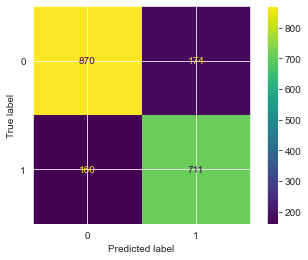

In [29]:
results_05={}
results_05['model'] = 'NaiveB_CVEC'
results_05['vectorizer'] = 'cvec'

# Instantiating a pipeline.
text_clf_pipe = Pipeline(
    [
    ('cvec', cvec),
    ('mNB', mNB)
    ])

#define params for GridSearchCV 
params_MNB = [
    {"mNB__alpha":[0.1,0.5,1]
    }
]

#define gridsearch:
gs_mnb = GridSearchCV(
    text_clf_pipe, 
    param_grid= params_MNB,
    cv=5,
    verbose=1,
    n_jobs=-1
    )

#fitting model
gs_mnb.fit(X_train,y_train)

#getting predictions
preds = gs_mnb.predict(X_test)

#plotting confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();


#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_05['accuracy'] = accuracy
results_05['recall'] = recall
results_05['precision'] = precision
results_05['f1_score'] = f1score
results_05['roc_auc'] = roc_auc

models_scores_list.append(results_05)

## `Logistic Regression`
---

Logistic regression is a supervised machine learning algorithm used for classification purposes. It is used when the data is in the form of binary, i.e., 0 and 1. We can use two functions for binary values,viz logistic function and sigmoid function
*https://www.sciencedirect.com/science/article/pii/S2666412722000101#:~:text=Logistic%20regression%20is%20a%20supervised,from%20one%20category%20or%20another.*

In [30]:
#LogisticRegression
lr= LogisticRegression()

LR with TF-IDF

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, 

Our F1 score is : 0.8007334963325183
Our Precision score is : 0.8562091503267973
Our accuracy score is : 0.8297650130548303
Our recall score is : 0.7520091848450058


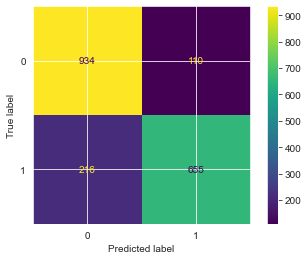

In [31]:
# Instantiating a pipeline.
results_06={}
results_06['model'] = 'LogisticR_TFIDF'
results_06['vectorizer'] = 'tvec'

text_clf_pipe = Pipeline(
    [
    ('tvec', tvec),
    ('lr_class', lr)
    ])

#define params for GridSearchCV 
params_lr = [
    {"lr_class__penalty":['l1','l2'],
    "lr_class__C":[0.1,0.5,1] #Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    }
]

#define gridsearch:
gs_lr = GridSearchCV(
    text_clf_pipe, 
    param_grid= params_lr,
    cv=5,
    verbose=1,
    n_jobs=-1
    )

#fitting model
gs_lr.fit(X_train,y_train)

#getting predictions
preds = gs_lr.predict(X_test)

#displaying confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_06['accuracy'] = accuracy
results_06['recall'] = recall
results_06['precision'] = precision
results_06['f1_score'] = f1score
results_06['roc_auc'] = roc_auc

models_scores_list.append(results_06)

LR with CVEC

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\galvi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\galvi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, 

Our F1 score is : 0.8181296615031554
Our Precision score is : 0.8176605504587156
Our accuracy score is : 0.8344647519582246
Our recall score is : 0.8185993111366245


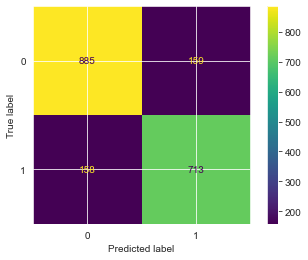

In [32]:
# Instantiating a pipeline.
results_07={}
results_07['model'] = 'LogisticR_CVEC'
results_07['vectorizer'] = 'cvec'

text_clf_pipe = Pipeline(
    [
    ('cvec', cvec),
    ('lr_class', lr)
    ])

#define params for GridSearchCV 
params_lr = [
    {"lr_class__penalty":['l1','l2'],
    "lr_class__C":[0.1,0.5,1] #Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    }
]

#define gridsearch:
gs_lr = GridSearchCV(
    text_clf_pipe, 
    param_grid= params_lr,
    cv=5,
    verbose=1,
    n_jobs=-1
    )

#fitting model
gs_lr.fit(X_train,y_train)

#getting predictions
preds = gs_lr.predict(X_test)

#displaying confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test,preds)
displ = ConfusionMatrixDisplay(cm)
displ.plot();

#getting the metrics ready
f1score=f1_score(y_test,preds)
precision=precision_score(y_test,preds)
accuracy=accuracy_score(y_test,preds)
recall=recall_score(y_test,preds)
roc_auc=roc_auc_score(y_test,preds)

print(f'Our F1 score is : {f1_score(y_test,preds)}')
print(f'Our Precision score is : {precision_score(y_test,preds)}')
print(f'Our accuracy score is : {accuracy_score(y_test,preds)}')
print(f'Our recall score is : {recall_score(y_test,preds)}')

# update various metrics onto results list
results_07['accuracy'] = accuracy
results_07['recall'] = recall
results_07['precision'] = precision
results_07['f1_score'] = f1score
results_07['roc_auc'] = roc_auc

models_scores_list.append(results_07)

c:\Users\galvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


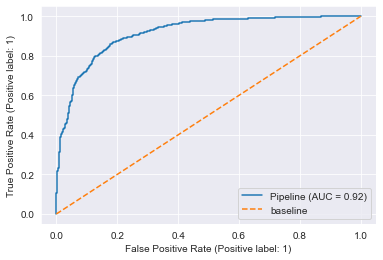

In [33]:
# plot the ROC curve
plot_roc_curve(gs_lr.best_estimator_, X_test, y_test);

# add the 50-50 scenario
plt.plot([0,1], [0,1],
         label = 'baseline',
         linestyle = '--');

# add a legend
plt.legend();

Logisitic regression tops all classification metrics and seems to be a clear winner for our goal. <br>
We wanted to be able to classify with **high accuracy** which subreddit does a comment or post belong to.
<br>

**Logistic regression provides the best results to classify our posts** We have not evaluated the performance compared to the training set for each model but from the baseline comparison, we see that training score is close to testing score, so we conclude that the model is not significantly overfit

### `On to metrics comparison`

With the help of lesson notebook + *https://towardsdatascience.com/confusion-matrix-un-confused-1ba98dee0d7f*

In [35]:
metrics_df = pd.DataFrame(models_scores_list)
metrics_df.head(10)

,model,vectorizer,accuracy,recall,precision,f1_score,roc_auc
0,pipe_tvec,tvec,0.810966,0.704937,0.853964,0.772327,0.802181
1,RandomF_TFIDF,tvec,0.800000,0.671642,0.857771,0.753381,0.789365
2,RandomF_CVEC,cvec,0.812533,0.676234,0.884384,0.766428,0.801240
3,NaiveB_TFIDF,tvec,0.827676,0.778416,0.831902,0.804270,0.823595
4,NaiveB_CVEC,cvec,0.825587,0.816303,0.803390,0.809795,0.824818
5,LogisticR_TFIDF,tvec,0.829765,0.752009,0.856209,0.800733,0.823323
6,LogisticR_CVEC,cvec,0.834465,0.818599,0.817661,0.818130,0.833150


Accuracy is our key metric here; <br>
First, all models seems to be performing well, around 80% accuracy, which means our data processing is not completely wrong ( the model makes mistakes but is able to get the majority of the subreddits correctly; **most important, it beats our baseline**)

**Logistic Regression** is our preferred model for this task and we would recommend Reddit to use it to classify posts.
<br>Reminder of Logistic regression strengths:<br>
- Quick to train data
- Work well for categorical data
- Simple parameterEstimation

## `Going further - sentiment analysis with Vader`
---

We could include a sentiment analysis feature in our post to filter for Starbucks / Dunkin. This would allow marketing teams to go and read specific comments without searching for too long

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # analyze sentiments using Vader library (implemented from technical paper)
sentiment = SentimentIntensityAnalyzer()
tokenizer = RegexpTokenizer(r'\w+')

In [37]:
#running tokenizer on the first comment
first_comment = tokenizer.tokenize(df_concat['selftext_lemmatized'][1])
first_comment

['a',
 'few',
 'week',
 'ago',
 'someone',
 'posted',
 'a',
 'comment',
 'about',
 'changing',
 'the',
 'zip',
 'code',
 'in',
 'the',
 'app',
 'to',
 '90001',
 'to',
 'get',
 'in',
 'early',
 'on',
 'the',
 'new',
 'reward',
 'program',
 'which',
 'suck',
 'and',
 'getting',
 'a',
 'free',
 'medium',
 'coffee',
 'by',
 'doing',
 'so',
 'well',
 'i',
 'did',
 'it',
 'and',
 'now',
 'i',
 'cannot',
 'change',
 'it',
 'back',
 'to',
 'my',
 'actual',
 'zip',
 'code',
 '2838',
 'mile',
 'to',
 'the',
 'east',
 'not',
 'only',
 'have',
 'i',
 'not',
 'been',
 'able',
 'to',
 'get',
 'the',
 'free',
 'medium',
 'coffee',
 'but',
 'any',
 'of',
 'the',
 'reward',
 'offer',
 'ive',
 'selected',
 'are',
 'redeemable',
 'in',
 'california',
 'only',
 'ive',
 'tried',
 'deleting',
 'and',
 're',
 'installing',
 'app',
 'amp',
 'accessing',
 'account',
 'on',
 'line',
 'to',
 'change',
 'it',
 'but',
 'the',
 'zip',
 'code',
 'field',
 'is',
 'locked',
 'i',
 'will',
 'email',
 'their',
 'custome

In [38]:
sentiment.polarity_scores(df_concat['selftext_lemmatized'][1])

{'neg': 0.015, 'neu': 0.819, 'pos': 0.165, 'compound': 0.9585}

Let's tag each comment with a sentiment prediction from VADER to analyze the data further

In [39]:
df_concat['vader_sentiment_pred']=''

In [40]:
def vader_sentiment_pred(review):
    vader_output = sentiment.polarity_scores(review)
# we're writing custom transformation because Vader uses a threshold of 0.05 to account for a 3rd Neutral sentiment that we don't have in our data set    
    if vader_output['compound'] < 0: # converting 'compound' polarity_score to 0s and 1s
        # negative
        return 0
    else:
        # positive
        return 1

df_concat['vader_sentiment_pred'] = df_concat['selftext_lemmatized'].apply(vader_sentiment_pred)
df_concat.head()

,subreddit,selftext,len_posts,selftext_lemmatized,vader_sentiment_pred
0,1,pumpkin small: $1.99\n\noriginal small: $2.29\...,282,pumpkin small 1 99 original small 2 29 pumpkin...,1
1,1,a few weeks ago someone posted a comment about...,622,a few week ago someone posted a comment about ...,1
2,1,"our nearest dunkin is a bit of a drive, and th...",212,our nearest dunkin is a bit of a drive and the...,1
3,1,how do i ask for an extra shot of flavor in th...,379,how do i ask for an extra shot of flavor in th...,1
4,1,i’ve used a can of monster and a variable amou...,134,i ve used a can of monster and a variable amou...,1


In [41]:
df_concat['vader_sentiment_pred'].value_counts()/len(df_concat)

1    0.71367
0    0.28633
Name: vader_sentiment_pred, dtype: float64

In [42]:
#for plotting purposes, we remove the outliers in len_post

In [43]:
df_concat_short=df_concat[df_concat['len_posts']<2000]

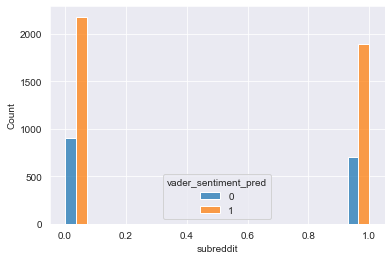

In [44]:
sns.histplot(
    data=df_concat_short
    ,hue= 'vader_sentiment_pred'
    ,x= 'subreddit'
    ,multiple='dodge'
    )
plt.show()

both subreddit have an equivalent % of positive and negative comments 

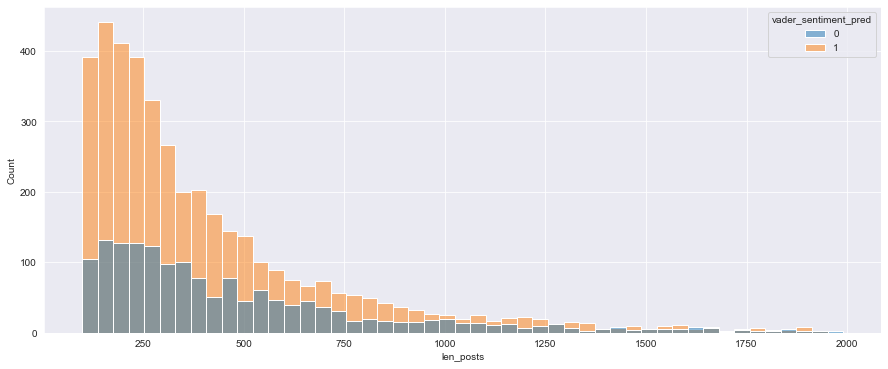

In [45]:
plt.figure(figsize=(15,6))
sns.histplot(
    data=df_concat_short,
    x= 'len_posts',
    hue ="vader_sentiment_pred"
    )
plt.show()

We realize that post shorter than 500 words are  2x-3x more likely to be positive comments